In [1]:
import collections
import math
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import os
import requests

# Process dataset

In [2]:
# download dataset by url
def Download(url, path):
    if not os.path.exists(path):
        response = requests.get(url)
        if response.status_code == 200:
            with open(path, 'wb') as file:
                file.write(response.content)
                print(f'successfully download data to {path}')
        else:
            print(f'failed to get response, error {response.status_code}')

In [3]:
Dataset_url = {
    "train":"https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt",
    "test":"https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt",
    "valid":"https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt"
}

root = "Datasets/PTB/"

# if dir is not exist, create a dir to store dataset
if not os.path.exists(root):
    os.mkdir(root)
    print(f"{root} created")

for name, url in Dataset_url.items():
    path = root + name + ".txt"
    Download(url, path)

In [4]:
# in ptb, end of sentence is <eof>, unknown words is <unk>, number is <N>
with open(root+"train.txt", 'r') as file:
    lines = file.readlines()
    raw_dataset = [st.split() for st in lines]

In [5]:
for st in raw_dataset[:3]:
    print(f"tokens {len(st)}, {st}")

tokens 24, ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter']
tokens 15, ['pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N']
tokens 11, ['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group']


In [6]:
# build word indices, for simplicity, we only save words appeared at least 5 times
counter = collections.Counter([tk for st in raw_dataset for tk in st])
counter = dict(filter(lambda x:x[1] >= 5, counter.items()))

# mapping words to indices
idx_to_token = {idx:tk[0] for idx,tk in enumerate(counter.items())}
token_to_idx = {tk:idx for idx, tk in idx_to_token.items()}

dataset = [[token_to_idx[tk] for tk in st if tk in token_to_idx] for st in raw_dataset]     # dataset & raw_dataset are 2d list
num_tokens = sum([len(st) for st in dataset])
print(f'number of tokens : {num_tokens}')     

number of tokens : 887100


In [7]:
# subsample
# every word in dataset has probability to be dropped, and p is max(1 - sqrt(t/f(word)), 0)
# f(word) = num_word / num_all, so the more frequent a word is, the more likely it is to be discarded
subsampled_dataset = []
random.seed(42)

for st in dataset:
    subsampled_st = []
    for tk in st:
        p = max(1- math.sqrt(1e-4 * num_tokens / counter[idx_to_token[tk]]), 0) # probability of being dropped
        if random.uniform(0, 1) > p:
            subsampled_st.append(tk)
    subsampled_dataset.append(subsampled_st)

num_subtk = sum(len(st) for st in subsampled_dataset)
print(f'tokens of subsampled_dataset : {num_subtk}')

tokens of subsampled_dataset : 376122


In [8]:
def get_center_and_context(dataset, max_window_size):
    centers, contexts = [], []
    for st in dataset:
        if len(st) < 2: # numbers of tokens must bigger than 2
            continue
        else:
            centers += st
            for center_i in range(len(st)):
                window_size = random.randint(1, max_window_size)
                indices = list(range(max(0, center_i - window_size), min(len(st), center_i + window_size + 1)))
                indices.remove(center_i)
                contexts.append([st[idx] for idx in indices])
    
    return centers, contexts

In [9]:
random.seed(42)
all_centers, all_contexts = get_center_and_context(dataset, 5)

In [10]:
print(all_centers[:5], all_contexts[:5])        # 1d list && 2d list
print([idx_to_token[s] for s in all_centers[:5]])
print([[idx_to_token[tk] for tk in st] for st in all_contexts[:5]])

[0, 1, 2, 3, 4] [[1], [0, 2], [0, 1, 3, 4, 5], [1, 2, 4, 5], [2, 3, 5, 6]]
['pierre', '<unk>', 'N', 'years', 'old']
[['<unk>'], ['pierre', 'N'], ['pierre', '<unk>', 'years', 'old', 'will'], ['<unk>', 'N', 'old', 'will'], ['N', 'years', 'will', 'join']]


In [11]:
# get negatives to make training faster
def get_negatives(all_contexts, sampling_weights, K):
    all_negatives, neg_candidates, i = [], [], 0
    population = list(range(len(sampling_weights))) # indices of tokens
    for context in all_contexts:
        negatives = []
        while len(negatives) < len(context) * K:    # every tk in context has 5 negative tks
            if i == len(neg_candidates):
                i, neg_candidates = 0, random.choices(population, sampling_weights, k=int(1e5))
            
            negatives.append(neg_candidates[i])
            i += 1
        all_negatives.append(negatives) # 2d list
    return all_negatives

In [12]:
sampling_weights = [(counter[tk]/num_tokens)**0.75 for idx, tk in idx_to_token.items()]
all_negatives = get_negatives(all_contexts, sampling_weights, 5)

In [13]:
print([[idx_to_token[tk] for tk in st] for st in all_contexts[:3]])
print([[idx_to_token[tk] for tk in st] for st in all_negatives[:3]])

[['<unk>'], ['pierre', 'N'], ['pierre', '<unk>', 'years', 'old', 'will']]
[['another', 'as', 'buyers', 'joint', 'in'], ['compelling', 'a', 'hopes', 'genuine', "'s", 'insurance', 'N', 'restructure', 'restated', 'the'], ['cds', '<unk>', 'container', 'chairman', 'new', 'race', 'when', 'probably', 'is', 'most', '1990s', 'kid', 'violated', 'serves', 'securities', 'businessman', 'york', 'any', 'after', 'show', 'oak', 'california', 'threat', 'said', 'and']]


In [14]:
# read dataset, create our own dataset and preprocess
class myDataset(torch.utils.data.Dataset):
    def __init__(self, all_centers, all_contexts, all_negatives):
        assert len(all_centers) == len(all_contexts) == len(all_negatives)
        self.centers = all_centers
        self.contexts = all_contexts
        self.negatives = all_negatives
    
    def __getitem__(self, index):
        return self.centers[index], self.contexts[index], self.negatives[index]
    
    def __len__(self):
        return len(self.centers)
    
def batchify(data):  # data is we get from myDataset (batch_size, 3, ...)
    max_len = max([len(c) + len(n) for _, c, n in data])
    
    centers, context_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        con_neg = context + negative
        context_negative = con_neg + [0] * (max_len - len(con_neg))
        mask = [1] * len(con_neg) + [0] * (max_len - len(con_neg))
        label = [1] * len(context) + [0] * (max_len - len(context))
        
        centers.append(center)
        context_negatives.append(context_negative)
        masks.append(mask)
        labels.append(label)
    
    return torch.tensor(centers).view(-1, 1), torch.tensor(context_negatives), torch.tensor(masks), torch.tensor(labels)

In [15]:
torch.manual_seed(42)

torch_Dataset = myDataset(all_centers, all_contexts, all_negatives)
data_iter = Data.DataLoader(torch_Dataset, batch_size=512, shuffle=True, collate_fn=batchify)
for data in data_iter:
    for t in data:
        print(t.shape)
    break

torch.Size([512, 1])
torch.Size([512, 60])
torch.Size([512, 60])
torch.Size([512, 60])


In [18]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)    # (512, 1, 100)
    u = embed_u(contexts_and_negatives) # (512, 60, 100)
    
    # A · B = |A|*|B|*cos(θ), show their similarity
    pred = torch.bmm(v, u.permute(0, 2, 1)) # (512, 1, 60)   similarity between center and contexts and negatives
    return pred

In [40]:
class sigmoidBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target, mask=None):
        input, target, mask = input.float(), target.float(), mask.float()
        res = F.binary_cross_entropy_with_logits(input, target, reduction="sum", weight=mask) # just use "sum" not "none", which will not consider those elements whose mask is 0?
        return res / mask.sum()
    
loss = sigmoidBinaryCrossEntropyLoss()

In [41]:
pred = torch.tensor([[1.5, 0.3, -1, 2], [1.1, -0.6, 2.2, 0.4]])
label = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 1, 0]]) # 掩码变量
loss(pred, label, mask)

tensor(1.0180)

# Build skip gram and train it

In [60]:
torch.manual_seed(42)
torch.cuda.empty_cache()

embed_size = 100
net = nn.Sequential(
    nn.Embedding(len(idx_to_token), embed_size),
    nn.Embedding(len(idx_to_token), embed_size),
) 
num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.to(device)
loss.to(device)

loss_i = []
idx = 0
for p in net.parameters():
    p.data *= 0.05

torch_Dataset = myDataset(all_centers, all_contexts, all_negatives)
for epoch in range(num_epochs):
    data_iter = Data.DataLoader(torch_Dataset, batch_size=512, shuffle=True, collate_fn=batchify)
    for data in data_iter:
        centers, context_negatives, masks, labels = [d.to(device) for d in data]
        pred = skip_gram(centers, context_negatives, net[0], net[1]).squeeze()    # (512, 60)
        l = loss(pred, labels, masks)
        
        # backward
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        # track stats
        loss_i.append(l.item())
        if idx % 200 == 0:
            print(f'idx {idx:7d} , loss {l.item():10f}')
        idx += 1

idx       0 , loss   0.693248
idx     200 , loss   0.421106
idx     400 , loss   0.403668
idx     600 , loss   0.401952
idx     800 , loss   0.399220
idx    1000 , loss   0.399000
idx    1200 , loss   0.396219
idx    1400 , loss   0.391629
idx    1600 , loss   0.400140
idx    1800 , loss   0.375268
idx    2000 , loss   0.380022
idx    2200 , loss   0.375297
idx    2400 , loss   0.390035
idx    2600 , loss   0.383200
idx    2800 , loss   0.384796
idx    3000 , loss   0.387262
idx    3200 , loss   0.383476
idx    3400 , loss   0.393316
idx    3600 , loss   0.366119
idx    3800 , loss   0.366256
idx    4000 , loss   0.368739
idx    4200 , loss   0.368542
idx    4400 , loss   0.378997
idx    4600 , loss   0.382528
idx    4800 , loss   0.374797
idx    5000 , loss   0.387482


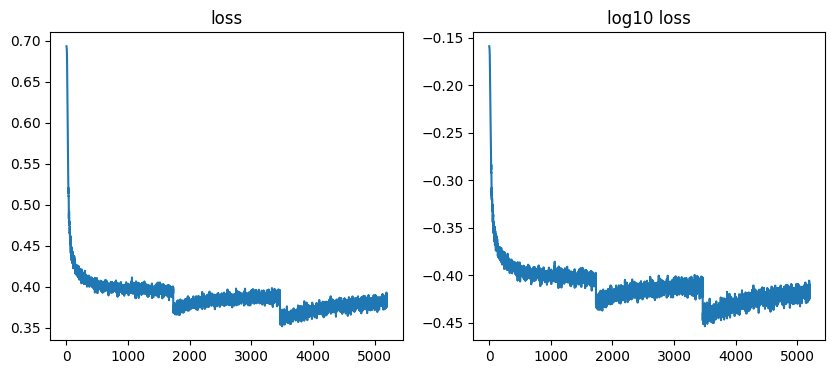

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(loss_i); plt.title("loss")
plt.subplot(1, 2, 2); plt.plot([math.log10(t) for t in loss_i]); plt.title("log10 loss")
plt.show()

In [63]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[token_to_idx[query_token]]
    # 添加的1e-9是为了数值稳定性
    cos = torch.matmul(W, x) / (torch.sum(W * W, dim=1) *
    torch.sum(x * x) + 1e-9).sqrt()
    _, topk = torch.topk(cos, k=k+1)
    topk = topk.cpu().numpy()
    for i in topk[1:]: # 除去输⼊词
        print('cosine sim=%.3f: %s' % (cos[i], (idx_to_token[i])))
 
get_similar_tokens('chip', 3, net[0])

cosine sim=0.520: intel
cosine sim=0.482: mainframes
cosine sim=0.480: machine
